In [1]:
import torch
import matplotlib.pyplot as plt
import os
import sys
import warnings
# module_path = os.path.abspath(os.path.join('TF_net'))
# if module_path not in sys.path:
#     sys.path.append(module_path)
from train import Dataset, train_epoch, eval_epoch, test_epoch, Scaler, preprocess
import torch.nn as nn
from torch.utils import data
from scipy import stats
from pathlib import Path
import numpy as np

def describe(x, axis=None):
    return stats.describe(x, axis)


class Args:
    pass

/home/lakshya/data/miniconda3/envs/tfnet/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
args = Args() 
args.data = 'data9_101.pt'


if args.data == "rbc_data.pt":
    compress = True
    permute = False
    offset=0
    transform_type = 'std'
    test_mode_train = False
elif args.data == 'data5.pt':
    compress = False
    permute = True
    offset = 60
    transform_type = 'std'
    split_spatially = False
elif 'data' in args.data and '101' in args.data:
    compress = False
    permute = True
    offset = 60
    transform_type = 'std'
    test_mode_train = True
else:
    raise ValueError("Un expected data file name")
args.transform = Scaler(transform_type, offset)


if Path(args.data).name == args.data: args.data = "../" + args.data #============================= extra line ========================================

data_prep = preprocess(args, permute, compress, test_mode=True)

tensor([-3.3224e-08])
tensor([2.3853]) <function Scaler.fit_transform.<locals>.<lambda> at 0x7f250020d280> <function Scaler.fit_transform.<locals>.<lambda> at 0x7f250020d280>


DescribeResult(nobs=1024, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=nan, kurtosis=nan)


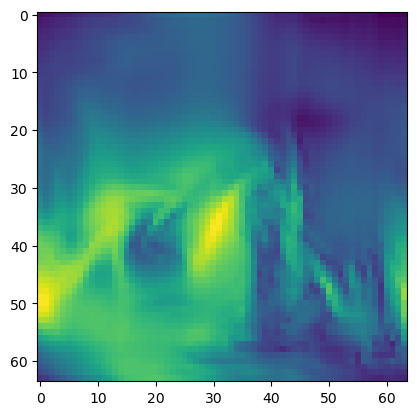

In [10]:
def plot_dft():
    idx=0
    signal = torch.linalg.norm(data_prep[idx], dim=0)
    fig, ax3 = plt.subplots(ncols=1)
    # ax1.imshow(signal)
    dft = torch.fft.fft2(signal)
    cutoff = int(0.5 * 64 )
    dft[cutoff:, cutoff:] = 0.0
    # ax2.imshow(torch.real(dft))
    idft = torch.fft.ifft2(dft)
    ax3.imshow(torch.real(idft))
    print(describe(torch.real(dft[32:,32:])))
    

plot_dft()

In [12]:
describe(data_prep)

DescribeResult(nobs=15892480, minmax=(-6.239602, 6.672698), mean=-5.8791674e-09, variance=1.0000007781786278, skewness=0.002974295591573106, kurtosis=0.6920954817340821)

In [15]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# d = 1, if using norm of velocity, else 2
def norm_each_sample(x, d=1):
    x = torch.clone(x)
    _max= torch.amax(x, dim=(d, d+1), keepdim=True) 
    _min= torch.amin(x, dim=(d, d+1), keepdim=True) 
    return (x - _min) / (_max - _min)

def plot(video, start=0, frames = None):
    print(video.shape)
    if frames is None:
        frames = video.shape[0]
    warnings.warn("Going to normalize each sample for visualizing purpose")
    video = norm_each_sample(video)
    fig = plt.figure() # figsize=(3,3)
    im = plt.imshow(video[start,:,:])

    plt.close() # this is required to not display the generated image

    def init():
        im.set_data(video[start,:,:])

    def animate(i):
        im.set_data(video[start+i,:,:])
        return im

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=frames,
                                interval=50)    #20 fps
    return anim.to_html5_video()

HTML(plot(torch.linalg.norm(data_prep, dim=1), 1800, 120))

torch.Size([1940, 64, 64])


In [5]:
test_indices = list(range(7700, 9800))
input_length = 26
time_range = 6
batch_size = 21
device = "cuda:"
device_ids = [1]
args.path = "../results/tfnet_data5_offset--dnsn_noise_4_wt_d_1e-5_enc_3/tfnet_data5_offset--dnsn_noise_4_wt_d_1e-5_enc_3_17/"
kernel_size=3
dropout_rate=0

device = torch.device(f"cuda:{device_ids[0]}" if torch.cuda.is_available() else "cpu")
loss_fun = torch.nn.MSELoss()

best_model = nn.DataParallel(torch.load(args.path+"model.pth", map_location=device).module, device_ids=device_ids)
data_prep = preprocess(args, permute, compress, test_mode=True)

print("Testing in test setting")
test_set = Dataset(test_indices, input_length + time_range - 1, 40, 60, data_prep, True,test_mode=True)
test_loader = data.DataLoader(test_set, batch_size = batch_size, shuffle = False, num_workers = 8)
preds, trues, loss_curve = test_epoch(args, test_loader, best_model, loss_fun, test_mode=True, save_preds= True, device=device)

torch.save({"loss_curve": loss_curve}, 
            args.path+"results.pt",pickle_protocol=5)

tensor([2.5539e-07])
tensor([0.1367]) <function Scaler.fit_transform.<locals>.<lambda> at 0x7efcc0b97430> <function Scaler.fit_transform.<locals>.<lambda> at 0x7efcc0b97430>
Testing in test setting


100%|██████████| 15/15 [00:51<00:00,  3.47s/it]


[0.00218984 0.00285727 0.00368678 0.00472838 0.00593745 0.00718588
 0.00855241 0.0099688  0.01150091 0.01300915 0.01460494 0.01627149
 0.01790799 0.01955256 0.02130437 0.02297975 0.02468692 0.02643708
 0.02821297 0.02998871 0.03175419 0.03352945 0.03534781 0.03710909
 0.03891163 0.04069062 0.04246245 0.04421741 0.04596258 0.04767891
 0.04937247 0.0510341  0.0526709  0.05426807 0.05582727 0.05735357
 0.05884445 0.06028743 0.06169782 0.06306663 0.06439881 0.0656922
 0.06694989 0.06817155 0.06935997 0.07051089 0.07163144 0.07271417
 0.07376252 0.07477588 0.07575466 0.07669669 0.07760661 0.07848344
 0.07933078 0.08014932 0.08094263 0.08171295 0.08246299 0.08319494]


In [12]:
j, xx, yy = next(iter(test_loader))
print((xx[0] == xx[1]).all())

tensor(True)


In [12]:
ndx = 52
ones = 0.1*np.ones_like(preds[ndx])
obs = np.concatenate((preds[ndx], ones, trues[ndx]),axis=2)
HTML(plot(torch.from_numpy(obs), 0))

In [17]:
HTML(plot(torch.from_numpy(preds[ndx]), 0))

In [21]:
print(stats.describe(preds, None))
print(stats.describe(trues, None))

(array([[ 0.,  0.,  7., ...,  0.,  0.,  0.],
        [ 0.,  0.,  7., ...,  0.,  0.,  0.],
        [ 0.,  0.,  7., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  9., 10., 11.],
        [ 0.,  0.,  0., ...,  9., 10., 11.],
        [ 0.,  0.,  0., ..., 10., 10., 11.]]),
 array([0.30961025, 0.30964309, 0.30967593, 0.3097088 , 0.30974165,
        0.30977449, 0.30980733, 0.30984017, 0.30987304, 0.30990589,
        0.30993873]),
 <a list of 448 BarContainer objects>)

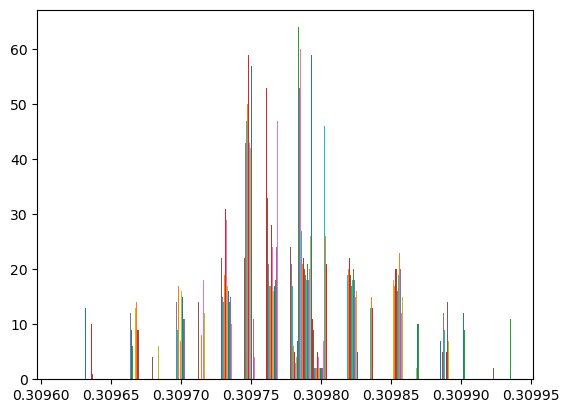

In [19]:
plt.hist(trues[ndx,0,0])

In [1]:
import torch

/home/lakshya/data/miniconda3/envs/tfnet/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
import torch
import numpy as np
def mask_gen(epoch, tile_sz=4, image_sz=64, start=15, end=85, lower = 80, upper=100):
    assert image_sz%tile_sz == 0    #code not tested for other cases
    mask_ratio = 0.01*min(upper, max(lower, lower + ((upper-lower)*(epoch-start))/(end-start)))
    iv,jv = [x.flatten() for x in np.meshgrid(np.arange(image_sz//tile_sz), np.arange(image_sz//tile_sz), indexing='ij')]
    mask_i = np.random.choice(len(iv), int(mask_ratio*len(iv)), replace=False)

    mask = torch.ones((image_sz,image_sz))
    for idx in zip(mask_i):
        i, j = iv[idx]*tile_sz, jv[idx]*tile_sz
        mask[i:i+tile_sz,j:j+tile_sz] = 0
    print(mask_ratio, (mask == 0).sum() / len(mask.flatten()))
    return mask
    
mask_gen(50)

0.9 tensor(0.8984)


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])